# DeepMoji Classifier

This is a workbook to sense test DeepMoji model.

# Data Preparation

In [118]:
import os, sys

In [172]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
source_dir = os.path.dirname(parent_dir)

print("Current dir:", current_dir)
print("Parent dir:", parent_dir)
print("Source dir:", source_dir)

# Add parent and source path to Python path
sys.path.insert(0, parent_dir)
sys.path.insert(0, source_dir)

Current dir: /Users/johnlingi/Documents/MSc_CS/Thesis/src/model/binary_classifier
Parent dir: /Users/johnlingi/Documents/MSc_CS/Thesis/src/model
Source dir: /Users/johnlingi/Documents/MSc_CS/Thesis/src


#### Loading the data
We load the joy and anger processed data sets setting joy labels to 0 and anger to 1.

In [173]:
from utils.file_io import load_multiple_processed, load_from_text
from sklearn.utils import shuffle

In [174]:
print("Did you check the root data path?")

Did you check the root data path?


In [175]:
root_data_path = source_dir + "/data/combined/10_tokens/"

In [176]:
emotions = {"joy":0, "anger":1}

### For supervised

In [7]:
x_train_orig = []
y_train_orig = []

file = "classifier_data_for_supervised.txt"
with open(root_data_path + file) as f:
    for line in f.readlines():
        t, l = line.strip().split(sep='\t')
        x_train_orig.append(t)
        y_train_orig.append(int(l))
    
assert len(x_train_orig) == len(y_train_orig)    

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train_orig, x_val_orig, y_train_orig, y_val_orig = train_test_split(x_train_orig, y_train_orig, test_size=0.2, stratify=y_train_orig)

In [10]:
len(x_train_orig), len(x_val_orig), len(y_train_orig), len(y_val_orig)

(794, 199, 794, 199)

### For Unsupervised

In [177]:
# # New
print("Loading training data from", "/".join(emotions.keys()), "datasets")
x_train_orig = []
y_train_orig = []
for emotion in emotions.keys():
    loaded_tweets = load_from_text(root_data_path + emotion + "-train.txt") 
    
    x_train_orig += loaded_tweets
    y_train_orig += [emotions[emotion]] * len(loaded_tweets)
    
assert len(x_train_orig) == len(y_train_orig)    

Loading training data from joy/anger datasets
Reading data from /Users/johnlingi/Documents/MSc_CS/Thesis/src/data/combined/10_tokens/joy-train.txt
Reading data from /Users/johnlingi/Documents/MSc_CS/Thesis/src/data/combined/10_tokens/anger-train.txt


In [178]:
# # New
print("Loading validation data from", "/".join(emotions.keys()), "datasets")
x_val_orig = []
y_val_orig = []
for emotion in emotions.keys():
    loaded_tweets = load_from_text(root_data_path + emotion + "-val.txt") 
    
    x_val_orig += loaded_tweets
    y_val_orig += [emotions[emotion]] * len(loaded_tweets)
    
assert len(x_val_orig) == len(y_val_orig)    

Loading validation data from joy/anger datasets
Reading data from /Users/johnlingi/Documents/MSc_CS/Thesis/src/data/combined/10_tokens/joy-val.txt
Reading data from /Users/johnlingi/Documents/MSc_CS/Thesis/src/data/combined/10_tokens/anger-val.txt


In [179]:
print("Num training:", len(x_train_orig), "\tNum validation:", len(x_val_orig))

Num training: 4094 	Num validation: 456


In [180]:
print("Training")
print("N class 0:", len(y_train_orig) - sum(y_train_orig), "\tN class 1:", sum(y_train_orig)) 

Training
N class 0: 2376 	N class 1: 1718


In [181]:
print("Validation")
print("N class 0:", len(y_val_orig) - sum(y_val_orig), "\tN class 1:", sum(y_val_orig)) 

Validation
N class 0: 265 	N class 1: 191


### Shuffle data

In [182]:
from sklearn.utils import shuffle

In [183]:
x_train_orig, y_train_orig = shuffle(x_train_orig, y_train_orig)
x_val_orig, y_val_orig = shuffle(x_val_orig, y_val_orig)

#### Sequence distribution

In [184]:
all_training = x_train_orig + x_val_orig
all_labels = y_train_orig + y_val_orig

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5,1,'Anger')

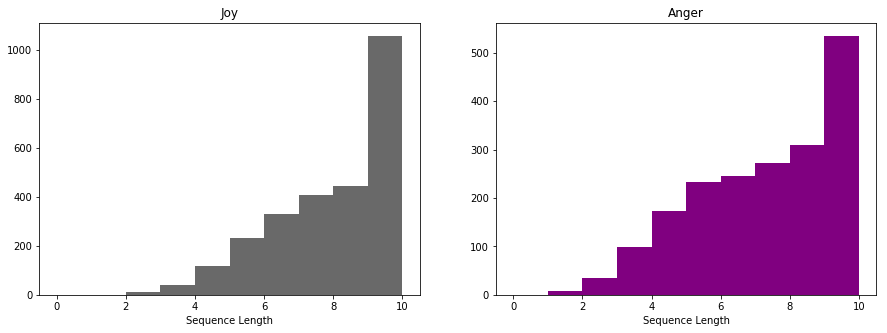

In [186]:
# Let's look at the distribution of our tweets and see what's the average number of tokens per tweet
joy_seq_len = [len(sent.split()) for (sent, label) in zip(all_training, all_labels) if label == 0]
anger_seq_len = [len(sent.split()) for (sent, label) in zip(all_training, all_labels) if label == 1]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(joy_seq_len, bins=range(max(joy_seq_len) + 1), color='dimgrey')
plt.xlabel("Sequence Length")
plt.title("Joy")

plt.subplot(1,2,2)
plt.hist(anger_seq_len, bins=range(max(anger_seq_len) + 1), color='purple')
plt.xlabel("Sequence Length")
plt.title("Anger")

#### Remove data

In [187]:
import numpy as np
from utils.model_utils import remove_sentences

In [188]:
MAX_SEQUENCE_LENGTH = 10
print("\nMAX SEQUENCE LENGTH:", MAX_SEQUENCE_LENGTH)


MAX SEQUENCE LENGTH: 10


In [189]:
print("Removing sentences that are greater than {0} tokens in length".format(MAX_SEQUENCE_LENGTH))

Removing sentences that are greater than 10 tokens in length


In [190]:
orig_length = len(x_train_orig)
x_train_orig, y_train_orig = remove_sentences(x_train_orig, y_train_orig, MAX_SEQUENCE_LENGTH)

print("Removed", orig_length - len(x_train_orig), "data points")

Removed 0 data points


In [191]:
orig_length = len(x_val_orig)
x_val_orig, y_val_orig = remove_sentences(x_val_orig, y_val_orig, MAX_SEQUENCE_LENGTH)

print("Removed", orig_length - len(x_val_orig), "data points")

Removed 0 data points


In [192]:
print("Num training:", len(x_train_orig), "\tNum validation:", len(x_val_orig))

Num training: 4094 	Num validation: 456


#### Add <eos\> token

In [193]:
from utils.model_utils import add_special_tokens

In [194]:
# Don't forget this appends
x_train = add_special_tokens(x_train_orig, end=True, end_token="<eos>")
x_val = add_special_tokens(x_val_orig, end=True, end_token="<eos>")

In [195]:
x_train[0]

'<user> and very nice it was too <smiling_face_with_smiling_eyes> <eos>'

#### Encode

In [196]:
from utils.model_utils import one_hot_data
from utils.file_io import load_pickle

In [197]:
# Load dictionary
print("Did you check the vocabulary path?")
vocab_path = source_dir + "/vocabulary/vocab_10.pl"
# vocab_path = source_dir + "/vocabulary/supervised_data_vocab_10_min_angry_joy1.pl"
vocab_size, word2id, id2word = load_pickle(vocab_path)
print("Loaded vocabulary of size", vocab_size)

Did you check the vocabulary path?
Loaded vocabulary of size 4805


In [198]:
# Now one-hot encode and return numpy array
x_train = one_hot_data(x_train, word2id, max_sequence_length=MAX_SEQUENCE_LENGTH + 1)  # +1 for eos
x_val = one_hot_data(x_val, word2id, max_sequence_length=MAX_SEQUENCE_LENGTH + 1)

In [199]:
print("X train input shape", x_train.shape)
print("X val input shape", x_val.shape)

X train input shape (4094, 11, 4805)
X val input shape (456, 11, 4805)


In [200]:
y_train = np.asarray(y_train_orig)
y_val = np.asarray(y_val_orig)

In [201]:
print("y train input shape", y_train.shape)
print("y val input shape", y_val.shape)

y train input shape (4094,)
y val input shape (456,)


### Training 

In [202]:
import os, sys
import keras
from keras.layers import Input, Bidirectional, Embedding, Dense, Dropout, SpatialDropout1D, LSTM, Activation, concatenate
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
import h5py
import numpy as np

In [203]:
from DeepMoji.deepmoji.attlayer import AttentionWeightedAverage

First phase is to test the raw architecture without changing the final softmax or the input vocabulary size.

In [204]:
weight_path = source_dir + "/DeepMoji/model/deepmoji_weights.hdf5"

In [205]:
def deepmoji_architecture(nb_classes, nb_tokens, maxlen, feature_output=False, embed_dropout_rate=0, final_dropout_rate=0, embed_l2=1E-6, return_attention=False):
    """
    Returns the DeepMoji architecture uninitialized and
    without using the pretrained model weights.
    # Arguments:
        nb_classes: Number of classes in the dataset.
        nb_tokens: Number of tokens in the dataset (i.e. vocabulary size).
        maxlen: Maximum length of a token.
        feature_output: If True the model returns the penultimate
                        feature vector rather than Softmax probabilities
                        (defaults to False).
        embed_dropout_rate: Dropout rate for the embedding layer.
        final_dropout_rate: Dropout rate for the final Softmax layer.
        embed_l2: L2 regularization for the embedding layerl.
    # Returns:
        Model with the given parameters.
    """
    # define embedding layer that turns word tokens into vectors
    # an activation function is used to bound the values of the embedding
    model_input = Input(shape=(maxlen, nb_tokens), dtype='float32')
#     embed_reg = L1L2(l2=embed_l2) if embed_l2 != 0 else None
#     embed = Embedding(input_dim=nb_tokens,
#                       output_dim=256,
#                       mask_zero=True,
#                       input_length=maxlen,
#                       embeddings_regularizer=embed_reg,
#                       name='embedding')
#     x = embed(model_input)
#     x = Activation('tanh')(x)

    x = Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(embed_l2), name="embedding")(model_input)

    # entire embedding channels are dropped out instead of the
    # normal Keras embedding dropout, which drops all channels for entire words
    # many of the datasets contain so few words that losing one or more words can alter the emotions completely
#     if embed_dropout_rate != 0:
#         embed_drop = SpatialDropout1D(embed_dropout_rate, name='embed_drop')
#         x = embed_drop(x)

    # skip-connection from embedding to output eases gradient-flow and allows access to lower-level features
    # ordering of the way the merge is done is important for consistency with the pretrained model
    lstm_0_output = Bidirectional(LSTM(512, return_sequences=True), name="bi_lstm_0")(x)
    lstm_1_output = Bidirectional(LSTM(512, return_sequences=True), name="bi_lstm_1")(lstm_0_output)
    x = concatenate([lstm_1_output, lstm_0_output, x])

    # if return_attention is True in AttentionWeightedAverage, an additional tensor
    # representing the weight at each timestep is returned
    weights = None
    x = AttentionWeightedAverage(name='attlayer', return_attention=return_attention)(x)
    if return_attention:
        x, weights = x

    if not feature_output:
        # output class probabilities
        if final_dropout_rate != 0:
            x = Dropout(final_dropout_rate)(x)

        if nb_classes > 2:
            outputs = [Dense(nb_classes, activation='softmax', name='softmax')(x)]
        else:
            outputs = [Dense(1, activation='sigmoid', name='softmax')(x)]
    else:
        # output penultimate feature vector
        outputs = [x]

    if return_attention:
        # add the attention weights to the outputs if required
        outputs.append(weights)

    return Model(inputs=[model_input], outputs=outputs, name="DeepMoji")

In [206]:
def get_weights_from_hdf5(filepath):
    """ Loads the weights from a saved Keras model into numpy arrays.
        The weights are saved using Keras 2.0 so we don't need all the
        conversion functionality for handling old weights.
    """

    with h5py.File(filepath, mode='r') as f:
        layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]
        layer_weights = []
        for k, l_name in enumerate(layer_names):
            g = f[l_name]
            weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
            weight_values = [g[weight_name][:] for weight_name in weight_names]
            
            if l_name == "embedding":
                weight_names.append("embedding/bias")
                weight_values.append(np.zeros_like(weight_values[0]))
            
            if len(weight_values):
                layer_weights.append([l_name, weight_names, weight_values])
        return layer_weights

In [207]:
get_weights_from_hdf5(weight_path)

[['embedding',
  ['embedding/embeddings', 'embedding/bias'],
  [array([[-9.3612674e-31,  4.3206305e-30, -4.9975794e-30, ...,
            1.7509513e-30, -4.9680868e-30,  5.6984690e-30],
          [-2.0108679e-01,  3.4220535e-02, -1.1772038e-01, ...,
           -6.6488728e-02,  1.7729569e-02, -4.3932866e-02],
          [ 4.1051465e-03,  1.1154222e-02,  5.4468300e-02, ...,
           -8.1048369e-02,  7.7828147e-02,  2.6068034e-02],
          ...,
          [-7.4952043e-04,  1.4409709e-03, -7.4346457e-03, ...,
            2.7252955e-04, -2.1748035e-03,  2.3946045e-03],
          [-1.8602223e-03, -2.7086639e-03,  3.5277866e-03, ...,
           -1.2746016e-03,  9.6934737e-04, -4.4170677e-04],
          [ 8.1022428e-03, -1.4600650e-03,  8.6887834e-05, ...,
           -5.8629974e-03, -7.1802684e-03,  1.9858165e-03]], dtype=float32),
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..

In [208]:
def load_specific_weights(model, weight_path, exclude_names=[], extend_embedding=0, verbose=True):
    """ Loads model weights from the given file path, excluding any
        given layers.

    # Arguments:
        model: Model whose weights should be loaded.
        weight_path: Path to file containing model weights.
        exclude_names: List of layer names whose weights should not be loaded.
        extend_embedding: Number of new words being added to vocabulary.
        verbose: Verbosity flag.

    # Raises:
        ValueError if the file at weight_path does not exist.
    """
    if not os.path.exists(weight_path):
        raise ValueError('ERROR (load_weights): The weights file at {} does '
                         'not exist. Refer to the README for instructions.'
                         .format(weight_path))

    if extend_embedding and 'embedding' in exclude_names:
        raise ValueError('ERROR (load_weights): Cannot extend a vocabulary '
                         'without loading the embedding weights.')

    # Copy only weights from the temporary model that are wanted
    # for the specific task (e.g. the Softmax is often ignored)
    layer_weights = get_weights_from_hdf5(weight_path)
    for i, w in enumerate(layer_weights):
        l_name = w[0]
        weight_names = w[1]
        weight_values = w[2]

        if l_name in exclude_names:
            if verbose:
                print('Ignoring weights for {}'.format(l_name))
            continue

        try:
            model_l = model.get_layer(name=l_name)
        except ValueError:
            raise ValueError("Weights had layer {},".format(l_name) +
                             " but could not find this layer in model.")

        if verbose:
            print('Loading weights for {}'.format(l_name))

        # extend embedding layer to allow new randomly initialized words
        # if requested. Otherwise, just load the weights for the layer.
        if type(model_l) is Embedding and extend_embedding > 0:
            comb_weights = append_to_embedding(weight_values,
                                               model_l.get_weights())
            model_l.set_weights(comb_weights)
#             if verbose:
#                 print('Extended vocabulary for embedding layer ' +
#                       'from {} to {} tokens.'.format(
#                           NB_TOKENS, NB_TOKENS + extend_embedding))
        else:
            model_l.set_weights(weight_values)

/Users/johnlingi/Documents/MSc_CS/Thesis/src/DeepMoji/model/deepmoji_weights.hdf5

In [209]:
model = deepmoji_architecture(2, vocab_size, MAX_SEQUENCE_LENGTH + 1)

In [210]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 11, 4805)     0                                            
__________________________________________________________________________________________________
embedding (Dense)               (None, 11, 256)      1230336     input_4[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 11, 1024)     3149824     embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       (None, 11, 1024)     6295552     bi_lstm_0[0][0]                  
__________________________________________________________________________________________________
concatenat

In [211]:
for layer in model.layers:
    print(layer.name, layer.get_weights())

input_4 []
embedding [array([[ 0.03010069,  0.02386356,  0.01812296, ...,  0.01977174,
        -0.01057303,  0.01263765],
       [-0.02211082, -0.01799971,  0.0080829 , ...,  0.01889696,
        -0.02299868, -0.01043765],
       [-0.01253119,  0.00162649,  0.00419164, ...,  0.02338772,
        -0.02441059,  0.01148248],
       ...,
       [ 0.02835956,  0.00677049,  0.00379978, ..., -0.03017405,
         0.00471088, -0.01198065],
       [-0.00359602,  0.0234503 , -0.01628151, ..., -0.00862359,
        -0.01570222, -0.00588544],
       [ 0.01537134, -0.02336092, -0.03280108, ..., -0.03012226,
         0.00516092, -0.01690649]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [213]:
load_specific_weights(model, weight_path=weight_path, exclude_names=['embedding','softmax'])

Ignoring weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax


In [159]:
for layer in model.layers:
    print(layer.name, layer.get_weights())

input_3 []
embedding [array([[ 0.01164941, -0.02839533, -0.00875643, ...,  0.03062141,
        -0.00947223,  0.0063174 ],
       [-0.0150374 ,  0.01721394, -0.02075509, ...,  0.03015098,
         0.01199418, -0.00978997],
       [-0.00052088,  0.0133955 ,  0.00277979, ..., -0.01558877,
        -0.01675268,  0.01566987],
       ...,
       [-0.02885852,  0.01909587, -0.00325266, ...,  0.03273148,
         0.02756812,  0.00399806],
       [-0.00392007,  0.0094837 , -0.02395779, ..., -0.02155123,
        -0.00135536, -0.03271471],
       [ 0.02710195,  0.0069591 , -0.02474798, ..., -0.02813755,
        -0.00969559,  0.00768508]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

#### Set biLSTM and attention layers as untrainable

In [160]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_3
1 embedding
2 bi_lstm_0
3 bi_lstm_1
4 concatenate_3
5 attlayer
6 softmax


In [161]:
for i, layer in enumerate(model.layers):
    if i == 1 or i == 6:
        layer.trainable = True
    else:
        layer.trainable = False

    print(layer.name, "trainable", layer.trainable)

input_3 trainable False
embedding trainable True
bi_lstm_0 trainable False
bi_lstm_1 trainable False
concatenate_3 trainable False
attlayer trainable False
softmax trainable True


In [162]:
adam = optimizers.Adam(lr=0.001, clipnorm=1)

In [163]:
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])

In [164]:
x_train.shape, y_train.shape

((4094, 11, 4805), (4094,))

In [165]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5)

# filepath = current_dir + "/10_tokens/deepmoji_checkpoint_supervised_{val_acc:.2f}_" + str(vocab_size) + ".h5"
# model_checkpoint = ModelCheckpoint(monitor='val_loss', filepath=filepath, save_best_only=True)

# callback_list = [early_stopping, model_checkpoint]
callback_list = [early_stopping]

In [166]:
model.fit(x=x_train, y=y_train,
         validation_data=(x_val, y_val),
         epochs=15,
         batch_size=32,
         callbacks=callback_list)

Train on 4094 samples, validate on 456 samples
Epoch 1/15
4094/4094 [==============================] - 47s 12ms/step - loss: 0.3181 - acc: 0.8544 - val_loss: 0.0767 - val_acc: 0.9693
Epoch 2/15
4094/4094 [==============================] - 38s 9ms/step - loss: 0.0239 - acc: 0.9932 - val_loss: 0.0572 - val_acc: 0.9825
Epoch 3/15
4094/4094 [==============================] - 38s 9ms/step - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0837 - val_acc: 0.9803
Epoch 4/15
4094/4094 [==============================] - 38s 9ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0480 - val_acc: 0.9825
Epoch 5/15
4094/4094 [==============================] - 38s 9ms/step - loss: 5.6919e-04 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9825
Epoch 6/15
4094/4094 [==============================] - 39s 9ms/step - loss: 4.7461e-04 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9825
Epoch 7/15
4094/4094 [==============================] - 37s 9ms/step - loss: 4.3422e-04 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.

### Testing the classifier

### Cross Validation 

In [47]:
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

In [52]:
def cross_val(x, y, folds=5, batch_size=32, epochs=50, callbacks=None):
    skf = StratifiedKFold(n_splits=folds)
    trained_models = []
    fold_counter = 0
    
    x, y = shuffle(x, y)
    
    for train_index, val_index in skf.split(x, y):
        # print("TRAIN:", train_index, "TEST:", val_index)
        print("Training for fold", fold_counter)
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = deepmoji_architecture(2, vocab_size, MAX_SEQUENCE_LENGTH + 1)
        load_specific_weights(model, weight_path=weight_path, exclude_names=['embedding', 'softmax'])

        # Define callbacks
        if callbacks is None:
            callback_list = []
        else: 
            callback_list = callbacks
        
        adam = optimizers.Adam(lr=0.001, clipnorm=1)
        model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])
#         train(model, x_train, y_train, x_val, y_val, batch_size, epochs, callbacks=callback_list)

        early_stopping = EarlyStopping(monitor='val_loss', patience=4)

        filepath = current_dir + "/deepmoji_checkpoint_{val_acc:.3f}_" + str(fold_counter) + ".h5"
        model_checkpoint = ModelCheckpoint(monitor='val_loss', filepath=filepath, save_best_only=True)

        callback_list = [early_stopping, model_checkpoint]

        model.fit(x=x_train, y=y_train,
             validation_data=(x_val, y_val),
             epochs=epochs,
             batch_size=batch_size,
             callbacks=callback_list)

        trained_models.append(model)
        fold_counter += 1

        y_preds = predict(model, x_val).squeeze()
        score = accuracy_score(y_val, y_preds)

        print(fold_counter, score)
        
        
    return trained_models

In [49]:
all_x = np.concatenate((x_train,x_val), axis=0)
all_y = np.concatenate((y_train,y_val), axis=0)

In [50]:
all_x.shape, all_y.shape

((4550, 11, 1200), (4550,))

In [53]:
trained_models = cross_val(all_x, all_y, epochs=5)

Training for fold 0
Ignoring weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
Train on 3639 samples, validate on 911 samples
Epoch 1/5
3639/3639 [==============================] - 18s 5ms/step - loss: 0.3266 - acc: 0.8368 - val_loss: 0.1014 - val_acc: 0.9616
Epoch 2/5
3639/3639 [==============================] - 14s 4ms/step - loss: 0.0676 - acc: 0.9769 - val_loss: 0.1001 - val_acc: 0.9748
Epoch 3/5
3639/3639 [==============================] - 14s 4ms/step - loss: 0.0341 - acc: 0.9923 - val_loss: 0.0866 - val_acc: 0.9759
Epoch 4/5
3639/3639 [==============================] - 14s 4ms/step - loss: 0.0227 - acc: 0.9937 - val_loss: 0.0724 - val_acc: 0.9791
Epoch 5/5
3639/3639 [==============================] - 14s 4ms/step - loss: 0.0101 - acc: 0.9967 - val_loss: 0.0616 - val_acc: 0.9824
1 0.9824368825466521
Training for fold 1
Ignoring weights for embedding
Loading weights for bi_lstm_0
Loading weig

# Plot 

In [55]:
import matplotlib.pyplot as plt

In [72]:
x = list(range(1,6))
y = [0.982, 0.983, 0.987, 0.981, 0.979]

In [77]:
plt.plot(x, y, '-o', color="dimgrey", markerfacecolor="thistle", linewidth=2, markersize=8)
plt.ylim(0.97, 0.99)
plt.xticks([0,1,2,3,4,5, 6])
plt.xlabel("Folds")
plt.ylabel("Validation Accuracy")
# plt.title("DeepMoji Classifier Evaluation")

In [36]:
# Small tests on this basic model
x_test_2 = ["excited am so angry <eos>",
            "today is a great day <eos>",            
            "that lady pisses me off <eos>",
            "fantastic , fantastic , fantastic <eos>",
            "why can not doctors just do their job properly ? <eos>",
            "i love my dada <eos>",
            "you look angry . <eos>",
            "we are all one big , happy family here . <eos>",
            "i was glad the movie had a happy ending . <eos>",
            "i am not happy with you . <eos>",
            "you are the best man <eos>",
            "i am so blessed <eos>",
            "i am happy happy <eos>",
            "i am happy <eos>",
            "very angry right now <eos>",
            "<user> lovely being home after spending some christmas overseas <laugh> <eos>",
            "<user> happy birthday keevie <eos>",
            "<user> happy new year girls las amo <happy> xx <eos>",
            "makes me so happy living my dream <eos>",
            "not been a good day at all ! <eos>",
            "<user> i hate this <curse> show ! hahaha <eos>",
            "sunflowers for in the . me me to much happy <eos>",
            "what a annoyed day <eos>",
            "love you"
         ]
          
x_test_2 = one_hot_data(x_test_2, word2id, MAX_SEQUENCE_LENGTH + 1)
y_test_2 = [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,0]

In [54]:
def predict(models, x_test):
    """
    model can be a list of models or a single model. If it's a list then a list of N predictions will be returned,
    where N is the number of models
    """
    
    if type(models) != list:
        preds = np.where(models.predict(x_test) <= 0.5, 0, 1)
    
    else:
        preds = []
        for model in models:
            single_prediction = np.where(model.predict(x_test) <= 0.5, 0, 1)
            preds.append(single_prediction)

    return preds

In [167]:
y_preds = predict(model, x_val).squeeze()
y_preds

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [168]:
from sklearn.metrics import accuracy_score

In [169]:
accuracy_score(y_val, y_preds)

0.9846491228070176

In [28]:
max_val_acc = max(model.history.history["val_acc"])

### Confusion matrix

In [170]:
from sklearn.metrics import confusion_matrix

In [171]:
confusion_matrix(y_val, y_preds)

array([[261,   4],
       [  3, 188]])

In [60]:
i = [index for index, (x, y) in enumerate(zip(y_preds, y_val)) if x != y]

In [61]:
x_val[i]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

### Save

In [129]:
name = ("{0}/10_tokens/binclassifier-deepmoji-{1}vocab-{2:.3f}valacc").format(
    current_dir, vocab_size, max_val_acc)

# print(name)
model.save(name + ".h5")
model.save_weights(name + "-weights.h5")

In [61]:
model2 = deepmoji_architecture(2, vocab_size, MAX_SEQUENCE_LENGTH + 1)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 11, 1149)     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 11, 256)      294400      input_2[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 11, 1024)     3149824     dense[0][0]                      
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       (None, 11, 1024)     6295552     bi_lstm_0[0][0]                  
__________________________________________________________________________________________________
concatenat

In [136]:
for layer in model2.layers:
    print(layer.name, layer.get_weights())

input_12 []
dense_11 [array([[ 0.0082101 ,  0.02194611,  0.04437649, ...,  0.03091791,
        -0.05529805, -0.00951282],
       [-0.02723595, -0.04059679,  0.059421  , ..., -0.00423997,
         0.06395378,  0.00870614],
       [ 0.05931743,  0.04443409,  0.04319543, ..., -0.03834653,
         0.02219452, -0.05314142],
       ...,
       [-0.02058833, -0.0104559 , -0.06487649, ...,  0.03083482,
        -0.01888899, -0.01164653],
       [-0.06145857, -0.06259874, -0.00567611, ..., -0.05450334,
         0.05725931, -0.02270739],
       [ 0.01043461,  0.03386308,  0.06551965, ..., -0.06256698,
        -0.03548014, -0.01769865]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [137]:
model2.load_weights("{0}/10_tokens/binclassifier-deepmoji-{1}vocab-{2:.3f}valacc-weights.h5".format(
    current_dir, vocab_size, max_val_acc))

In [138]:
for layer in model.layers:
    print(layer.name, layer.get_weights())

input_10 []
dense_9 [array([[-3.94295268e-02, -5.56237251e-02,  2.30651088e-02, ...,
        -1.03789195e-01, -1.77311059e-02, -3.29710618e-02],
       [ 6.64706477e-07,  1.99140775e-08, -3.85813514e-09, ...,
         1.39839733e-06,  6.81337099e-07, -1.90811278e-09],
       [-3.62048959e-05, -4.96004410e-02, -1.33106182e-03, ...,
        -2.59615127e-02,  1.27630442e-01, -2.19248496e-02],
       ...,
       [-2.62548607e-02, -1.07861068e-02, -3.62426266e-02, ...,
         4.54479493e-02,  4.21636440e-02, -1.25828572e-02],
       [-1.95599943e-02, -3.61664593e-02, -1.06424326e-03, ...,
         1.02805924e-02, -5.69591345e-03, -5.09544043e-03],
       [ 7.69318594e-03,  1.50013976e-02,  4.95428406e-02, ...,
         2.38162093e-02, -2.49053519e-02, -5.07436953e-02]], dtype=float32), array([-0.00232278, -0.05049528, -0.01537188, -0.02863859, -0.00710748,
       -0.00245248, -0.00397642,  0.01725892,  0.01367354, -0.02581758,
       -0.071977  ,  0.01809688, -0.02811628, -0.01476077,  0.

In [149]:
weights_arr = get_weights_from_hdf5("{0}/10_tokens/binclassifier-deepmoji-{1}vocab-{2:.3f}valacc-weights.h5".format(
    current_dir, vocab_size, max_val_acc))

In [150]:
weights_arr

[['dense_9',
  ['dense_9/kernel:0', 'dense_9/bias:0'],
  [array([[-3.94295268e-02, -5.56237251e-02,  2.30651088e-02, ...,
           -1.03789195e-01, -1.77311059e-02, -3.29710618e-02],
          [ 6.64706477e-07,  1.99140775e-08, -3.85813514e-09, ...,
            1.39839733e-06,  6.81337099e-07, -1.90811278e-09],
          [-3.62048959e-05, -4.96004410e-02, -1.33106182e-03, ...,
           -2.59615127e-02,  1.27630442e-01, -2.19248496e-02],
          ...,
          [-2.62548607e-02, -1.07861068e-02, -3.62426266e-02, ...,
            4.54479493e-02,  4.21636440e-02, -1.25828572e-02],
          [-1.95599943e-02, -3.61664593e-02, -1.06424326e-03, ...,
            1.02805924e-02, -5.69591345e-03, -5.09544043e-03],
          [ 7.69318594e-03,  1.50013976e-02,  4.95428406e-02, ...,
            2.38162093e-02, -2.49053519e-02, -5.07436953e-02]], dtype=float32),
   array([-0.00232278, -0.05049528, -0.01537188, -0.02863859, -0.00710748,
          -0.00245248, -0.00397642,  0.01725892,  0.013673

In [106]:
from keras.models import load_model

In [92]:
# model2 = load_model(current_dir + "/deepmoji_checkpoint_0.987_4.h5")

In [62]:
model2.load_weights(current_dir + "/10_tokens/deepmoji_checkpoint_supervised_0.82_1149.h5")

In [63]:
model2.save_weights(current_dir + "/deepmoji_checkpoint_supervised_0.82_1149_weights.h5")